In [1]:
# Libraries

import argparse
import numpy
import os
import platform
import shutil
import sys

In [2]:
# Ensure source path

ROOT = os.getcwd()

while not ROOT.endswith('upolanc-thesis') :
	ROOT = os.path.abspath(os.path.join(ROOT, os.pardir))

	if len(ROOT) < len('upolanc-thesis') :
		if   platform.system() == 'Linux' :
			ROOT = '/d/hpc/home/up4472/workspace/upolanc-thesis'
		elif platform.system() == 'Windows' :
			ROOT = 'C:\\Developer\\Workspace\\PyCharm\\Projects\\upolanc-thesis'
		else :
			raise ValueError()

		print(f'Warning : could not find correct directory, using default : {ROOT}')
		break

if ROOT not in sys.path :
	sys.path.append(ROOT)

os.chdir(ROOT)

In [3]:
# Code

from source.python.cnn.models import Zrimec2020r

from source.python.dataset import dataset_split
from source.python.dataset import dataset_utils
from source.python.cnn     import cnn_model
from source.python.cnn     import cnn_mutation
from source.python.cnn     import cnn_plot
from source.python.cnn     import cnn_utils
from source.python.io      import loader
from source.python.io      import writer
from source.python         import runtime

runtime.set_numpy_format()
runtime.set_pandas_format()
runtime.set_plot_theme()

# 1. Setup

In [4]:
# Setup some directory paths.

CWD = ROOT
OUT = os.path.join(CWD, 'output')
RES = os.path.join(CWD, 'resources')

OUT_DATA  = os.path.join(OUT,      'nbp07-zrimec', 'rm')
OUT_MODEL = os.path.join(OUT_DATA, 'model')
OUT_PLOT  = os.path.join(OUT_DATA, 'plot')
RES_NBP02 = os.path.join(OUT,      'nbp02-anndata')
RES_NBP04 = os.path.join(OUT,      'nbp04-feature')
RES_NBP05 = os.path.join(OUT,      'nbp05-target')

shutil.rmtree(OUT_DATA, ignore_errors = True)

os.makedirs(OUT_DATA,  exist_ok = True)
os.makedirs(OUT_MODEL, exist_ok = True)
os.makedirs(OUT_PLOT,  exist_ok = True)

print(f'     Root Directory : {CWD}')
print(f'   Output Directory : {OUT_DATA}')
print(f'   Output Directory : {OUT_MODEL}')
print(f'   Output Directory : {OUT_PLOT}')
print(f' Resource Directory : {RES_NBP04}')
print(f' Resource Directory : {RES_NBP05}')

     Root Directory : C:\Developer\Workspace\PyCharm\Projects\upolanc-thesis
   Output Directory : C:\Developer\Workspace\PyCharm\Projects\upolanc-thesis\output\nbp07-zrimec\rm
   Output Directory : C:\Developer\Workspace\PyCharm\Projects\upolanc-thesis\output\nbp07-zrimec\rm\model
   Output Directory : C:\Developer\Workspace\PyCharm\Projects\upolanc-thesis\output\nbp07-zrimec\rm\plot
 Resource Directory : C:\Developer\Workspace\PyCharm\Projects\upolanc-thesis\output\nbp04-feature
 Resource Directory : C:\Developer\Workspace\PyCharm\Projects\upolanc-thesis\output\nbp05-target


In [5]:
# System and device

DEVICE = runtime.get_device(only_cpu = False)
SYSTEM = runtime.get_system_info()

for key, value in SYSTEM.items() :
	print('{:25s} : {}'.format(key, value))

platform/python           : 3.10.7
platform/system           : Windows
platform/release          : 10
platform/version          : 10.0.19044
platform/cpu/name         : N/A
platform/cpu/count        : 12
platform/gpu/name         : NVIDIA GeForce RTX 3060 Ti
platform/gpu/available    : True
platform/gpu/count        : 1
platform/memory/total     : 31.924 GB
platform/memory/available : 12.854 GB


In [6]:
# Load the input transcript features

mutation_sequence_bp2150 = loader.load_fasta(
	filename  = os.path.join(RES_NBP04, 'mutation-sequences-bp2150.fasta'),
	to_string = True
)

mutation_feature_base = loader.load_npz(
	filename = os.path.join(RES_NBP04, 'mutation-features-base.npz')
)

sequence_bp2150 = loader.load_fasta(
	filename  = os.path.join(RES_NBP04, 'sequences-bp2150.fasta'),
	to_string = True
)

feature_base = loader.load_npz(
	filename = os.path.join(RES_NBP04, 'features-base.npz')
)

model_config = loader.load_json(
	filename = os.path.join(RES, 'tuner', 'zrimec2020.json')
)

# 2. Config

In [7]:
# Create final report

final_report = dict()

In [8]:
# Define output and inputs

MODEL_PARAMS   = None
MODEL_EPOCHS   = 15

TARGET_GROUP   = 'global'
TARGET_TYPE    = 'mean'
TARGET_EXPLODE = False
TARGET_FILTER  = None
TARGET_SIZE    = None

INPUT_FEATURES = None

In [9]:
# Check for args

if __name__ == '__main__' and 'get_ipython' in dir() :
	print('Running as .ipynb')

if __name__ == '__main__' and 'get_ipython' not in dir() :
	print('Running as .py')

	parser = argparse.ArgumentParser()

	str_of_bool = lambda x : True if x == 'true' else False
	str_or_none = lambda x : None if x == 'none' else str(x)
	int_or_none = lambda x : None if x == 'none' else int(x)

	_groups = ['tissue', 'group', 'age', 'global', 'perturbation']
	_types  = ['mean', 'max']

	parser.add_argument('--target_group',   type = str,         default = 'global', choices = _groups)
	parser.add_argument('--target_type',    type = str,         default = 'mean',   choices = _types)
	parser.add_argument('--target_explode', type = str_of_bool, default = False)
	parser.add_argument('--target_filter',  type = str_or_none, default = None)
	parser.add_argument('--model_epochs',   type = int,         default = 250)
	parser.add_argument('--model_params',   type = int_or_none, default = None)

	args = vars(parser.parse_args())

	TARGET_GROUP   = args['target_group']
	TARGET_TYPE    = args['target_type']
	TARGET_EXPLODE = args['target_explode']
	TARGET_FILTER  = args['target_filter']
	MODEL_EPOCHS   = args['model_epochs']
	MODEL_PARAMS   = args['model_params']

if TARGET_GROUP == 'global' :
	TARGET_EXPLODE = False

Running as .ipynb


In [10]:
# Load features

filters = {
	'tissue'       : None,
	'group'        : None,
	'age'          : None,
	'perturbation' : None,
	'global'       : None,
} | {
	TARGET_GROUP : TARGET_FILTER
	if TARGET_FILTER is None
	else [TARGET_FILTER]
}

dataframe, target_value, target_order = loader.load_feature_targets(
	group     = '{}-{}'.format(TARGET_GROUP, TARGET_TYPE),
	explode   = TARGET_EXPLODE,
	filters   = filters,
	directory = RES_NBP05,
	filename  = 'mapping-grouped.pkl',
	mode      = 'regression'
)


if 'Feature' in dataframe.columns :
	feature_base = {
		key : numpy.concatenate((feature_base[key.split('?')[-1]], value))
		for key, value in dataframe['Feature'].to_dict().items()
	}

TARGET_SIZE   = len(target_order)
INPUT_FEATURE = len(list(feature_base.values())[0])

dataframe

,Transcript,TPM_Value,TPM_Label,Global
AT1G01010.1,AT1G01010.1,[1.761241756101558],[1],[global]
AT1G01020.1,AT1G01020.1,[1.0866479101651763],[0],[global]
AT1G01030.1,AT1G01030.1,[1.0235488805181145],[0],[global]
AT1G01040.1,AT1G01040.1,[1.6519999764364053],[1],[global]
AT1G01050.1,AT1G01050.1,[3.2601375485355275],[2],[global]
...,...,...,...,...
AT5G67600.1,AT5G67600.1,[3.2010419178026743],[2],[global]
AT5G67610.1,AT5G67610.1,[1.8563512356941414],[1],[global]
AT5G67620.1,AT5G67620.1,[0.9904034477856412],[0],[global]
AT5G67630.1,AT5G67630.1,[2.4249098838660283],[2],[global]


In [11]:
# Single global config

CONFIG = {
	'core/random'                  : None,
	'core/verbose'                 : False,
	'core/device'                  : DEVICE,
	'core/rootdir'                 : ROOT,
	'dataset/expanddim'            : None,
	'dataset/batch/train'          : 64,
	'dataset/batch/valid'          : 64,
	'dataset/batch/test'           : 64,
	'dataset/split/valid'          : 0.2,
	'dataset/split/test'           : 0.2,
	'criterion/name'               : 'mse',
	'criterion/reduction'          : 'mean',
	'optimizer/decay'              : 0.049112288361090203,
	'optimizer/lr'                 : 0.000855269783800900,
	'optimizer/beta1'              : 0.830793559890461997,
	'optimizer/beta2'              : 0.999000000000000000,
	'optimizer/name'               : 'adam',
	'scheduler/exponential/factor' : 0.993206525568888998,
	'scheduler/linear/factor'      : 0.044580434349908597,
	'scheduler/name'               : 'linear',
	'scheduler/plateau/factor'     : 0.255073201804133176,
	'scheduler/plateau/patience'   : 24,
	'model/input/channels'         : 1,
	'model/input/height'           : 4,
	'model/input/width'            : 2150,
	'model/input/features'         : INPUT_FEATURE,
	'model/epochs'                 : MODEL_EPOCHS,
	'model/dropout'                : 0.09,
	'model/leakyrelu'              : 0.00,
	'model/conv1/dilation'         : 1,
	'model/conv1/filters'          : 256,
	'model/conv1/kernel'           : 11,
	'model/conv1/padding'          : 'none',
	'model/conv2/dilation'         : 1,
	'model/conv2/filters'          : 32,
	'model/conv2/kernel'           : 5,
	'model/conv2/padding'          : 'none',
	'model/conv3/dilation'         : 1,
	'model/conv3/filters'          : 32,
	'model/conv3/kernel'           : 31,
	'model/conv3/padding'          : 'none',
	'model/maxpool1/kernel'        : 5,
	'model/maxpool1/padding'       : 'same',
	'model/maxpool2/kernel'        : 5,
	'model/maxpool2/padding'       : 'same',
	'model/maxpool3/kernel'        : 9,
	'model/maxpool3/padding'       : 'same',
	'model/fc1/features'           : 64,
	'model/fc2/features'           : 128,
	'model/fc3/features'           : TARGET_SIZE,
	'model/output/target'          : TARGET_GROUP,
	'model/output/type'            : TARGET_TYPE,
	'model/output/size'            : TARGET_SIZE,
	'model/params/id'              : MODEL_PARAMS
}

CONFIG['core/random'] = runtime.lock_random(
	seed     = CONFIG['core/random'],
	generate = True
)

In [12]:
# Update specific params

if CONFIG['model/params/id'] is not None and CONFIG['model/params/id'] >= 0 :
	CONFIG.update(model_config[CONFIG['model/params/id']])

In [13]:
# Prints

print('Input Feature : {}'.format(CONFIG['model/input/features']))
print('Output Target : {}'.format(CONFIG['model/output/target']))
print('Output Type   : {}'.format(CONFIG['model/output/type']))
print('Output Size   : {}'.format(CONFIG['model/output/size']))
print('Random Seed   : {}'.format(CONFIG['core/random']))

Input Feature : 72
Output Target : global
Output Type   : mean
Output Size   : 1
Random Seed   : 481160826


# 3. Dataloaders

## 3.1 Normal

In [14]:
# Create dataset

dataset = dataset_utils.to_gene_dataset(
	sequences   = sequence_bp2150,
	features    = feature_base,
	targets     = target_value,
	expand_dims = CONFIG['dataset/expanddim'],
	groups      = None
)

In [15]:
# Create dataloader

dataloaders = dataset_utils.to_dataloaders(
	dataset     = dataset,
	generator   = dataset_split.generate_group_shuffle_split,
	random_seed = CONFIG['core/random'],
	split_size  = {
		'valid' : CONFIG['dataset/split/valid'],
		'test'  : CONFIG['dataset/split/test']
	},
	batch_size  = {
		'train' : CONFIG['dataset/batch/train'],
		'valid' : CONFIG['dataset/batch/valid'],
		'test'  : CONFIG['dataset/batch/test']
	}
)

train_dataloader = dataloaders[0]
valid_dataloader = dataloaders[1]
test_dataloader  = dataloaders[2]

In [16]:
# Display train dataloader

dataset_utils.show_dataloader(
	dataloader = train_dataloader,
	verbose    = CONFIG['core/verbose']
)

In [17]:
# Display valid dataloader

dataset_utils.show_dataloader(
	dataloader = valid_dataloader,
	verbose    = CONFIG['core/verbose']
)

In [18]:
# Display test dataloader

dataset_utils.show_dataloader(
	dataloader = test_dataloader,
	verbose    = CONFIG['core/verbose']
)

## 3.2 Mutation

In [19]:
# Update mutation features

if 'Feature' in dataframe.columns :
	mutation_feature_base_new = dict()

	for x in mutation_feature_base.keys() :
		df = dataframe.loc[dataframe['Transcript'] == x.split('-')[0]]

		for index, row in df.iterrows() :
			key = index + '-' + x.split('-')[-1]
			val = numpy.concatenate((mutation_feature_base[x], row['Feature']))

			mutation_feature_base_new[key] = val

	mutation_feature_base = mutation_feature_base_new

In [20]:
# Create mutation dataloader

mutation_dataloader = cnn_mutation.create_dataloader(
	sequences   = mutation_sequence_bp2150,
	features    = mutation_feature_base,
	targets     = target_value,
	expand_dims = CONFIG['dataset/expanddim']
)

In [21]:
# Display mutation dataloader

dataset_utils.show_dataloader(
	dataloader = mutation_dataloader,
	verbose    = CONFIG['core/verbose']
)

# 4. Model

## 4.1 Structure

In [22]:
# Create and display the model structure

model = Zrimec2020r(params = CONFIG)

model.summary(
	batch_size  = CONFIG['dataset/batch/train'],
	in_height   = CONFIG['model/input/height'],
	in_width    = CONFIG['model/input/width'],
	in_features = CONFIG['model/input/features'],
)

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #
Zrimec2020r                              [64, 4, 2150]             [64, 1]                   --
├─Zrimec2020: 1-1                        [64, 4, 2150]             [64, 128]                 --
│    └─Conv1d: 2-1                       [64, 4, 2150]             [64, 256, 2140]           11,520
│    └─LeakyReLU: 2-2                    [64, 256, 2140]           [64, 256, 2140]           --
│    └─BatchNorm1d: 2-3                  [64, 256, 2140]           [64, 256, 2140]           512
│    └─Dropout: 2-4                      [64, 256, 2140]           [64, 256, 2140]           --
│    └─MaxPool1d: 2-5                    [64, 256, 2140]           [64, 256, 428]            --
│    └─Conv1d: 2-6                       [64, 256, 428]            [64, 32, 424]             40,992
│    └─LeakyReLU: 2-7                    [64, 32, 424]             [64, 32, 424]             --
│    └─BatchNorm1d: 2-8   

In [23]:
# Convert the model to double and initialize weights and biases

model = model.double()
model = model.apply(cnn_model.he_uniform_weight)
model = model.apply(cnn_model.zero_bias)

## 4.2 Metrics

In [24]:
# Define metrics

METRICS = {
	'mse'   : cnn_model.get_criterion(reduction = 'none', weights = None, query = 'mse'),
	'mae'   : cnn_model.get_criterion(reduction = 'none', weights = None, query = 'mae'),
	'r2'    : cnn_model.get_criterion(reduction = 'none', weights = None, query = 'r2', output_size = CONFIG['model/output/size']),
	'mape'  : cnn_model.get_criterion(reduction = 'none', weights = None, query = 'mape'),
	'wmape' : cnn_model.get_criterion(reduction = 'none', weights = None, query = 'wmape')
}

METRICS = {
	k : v.to(DEVICE)
	for k, v in METRICS.items()
}

## 4.3 Parameters

In [25]:
# Set the model parameters

model_trainers = cnn_model.get_model_trainers(
	model  = model,
	config = CONFIG,
	epochs = CONFIG['model/epochs']
)

model_params = {
	'model'     : model,
	'savebest'  : os.path.join(OUT_MODEL, f'{model.__name__}-best.pth'),
	'savelast'  : os.path.join(OUT_MODEL, f'{model.__name__}-last.pth'),
	'epochs'    : CONFIG['model/epochs'],
	'criterion' : model_trainers['criterion'],
	'optimizer' : model_trainers['optimizer'],
	'scheduler' : model_trainers['scheduler'],
	'device'    : DEVICE,
	'verbose'   : CONFIG['core/verbose'],
	'metrics'   : METRICS,
	'train_dataloader' : train_dataloader,
	'valid_dataloader' : valid_dataloader,
	'test_dataloader'  : test_dataloader
}

## 4.4 Training

In [26]:
# Train and validate the model

report = cnn_model.train_regressor(
	model  = model,
	params = model_params
)

## 4.5 Visualization

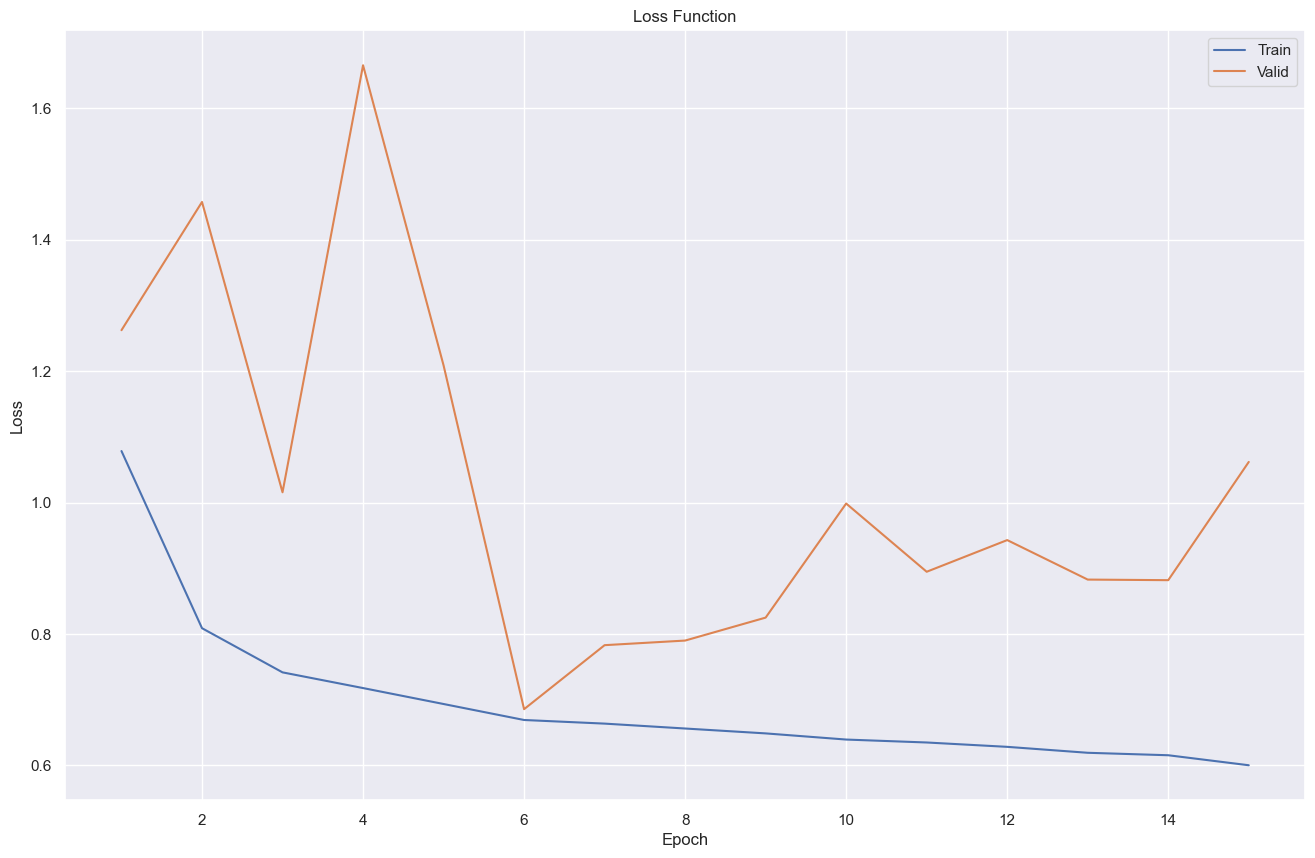

In [27]:
# Display the training and validation loss curves

cnn_plot.show_loss(
	report   = report,
	title    = 'Loss Function',
	filename = os.path.join(OUT_PLOT, model.__name__)
)

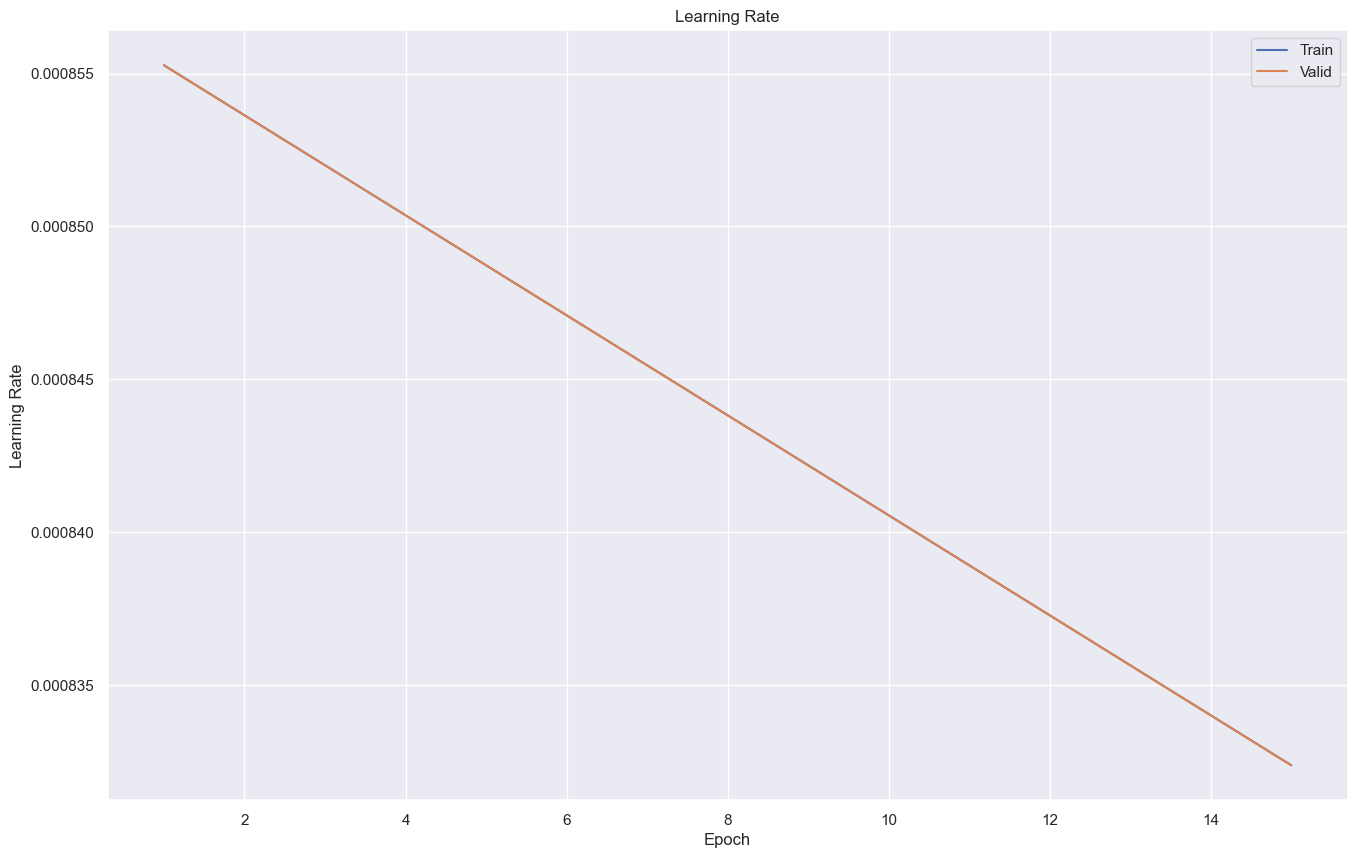

In [28]:
# Display the training and validation learning rate curves

cnn_plot.show_lr(
	report   = report,
	title    = 'Learning Rate',
	filename = os.path.join(OUT_PLOT, model.__name__)
)

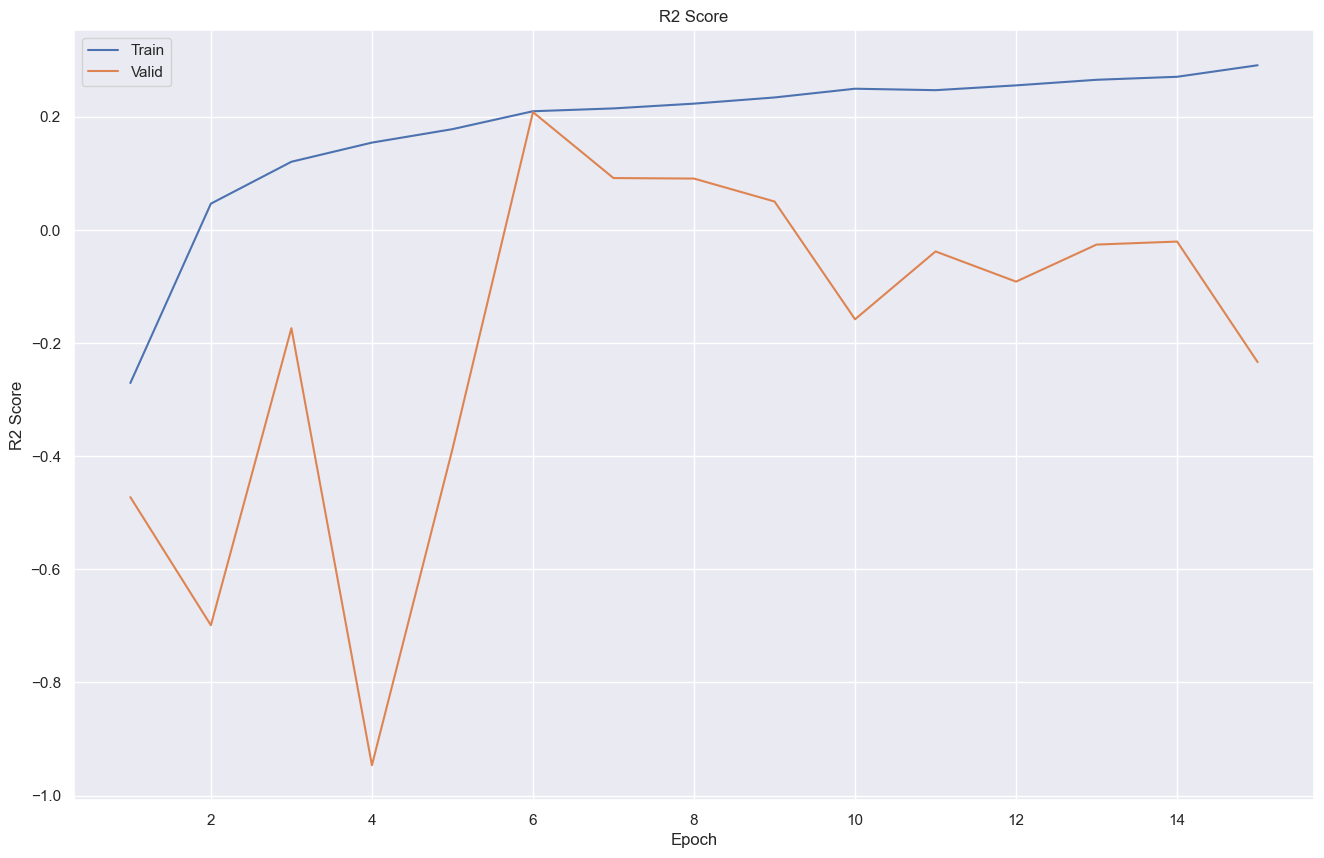

In [29]:
# Display the training and validation r2 score curves

cnn_plot.show_r2(
	report   = report,
	title    = 'R2 Score',
	filename = os.path.join(OUT_PLOT, model.__name__)
)

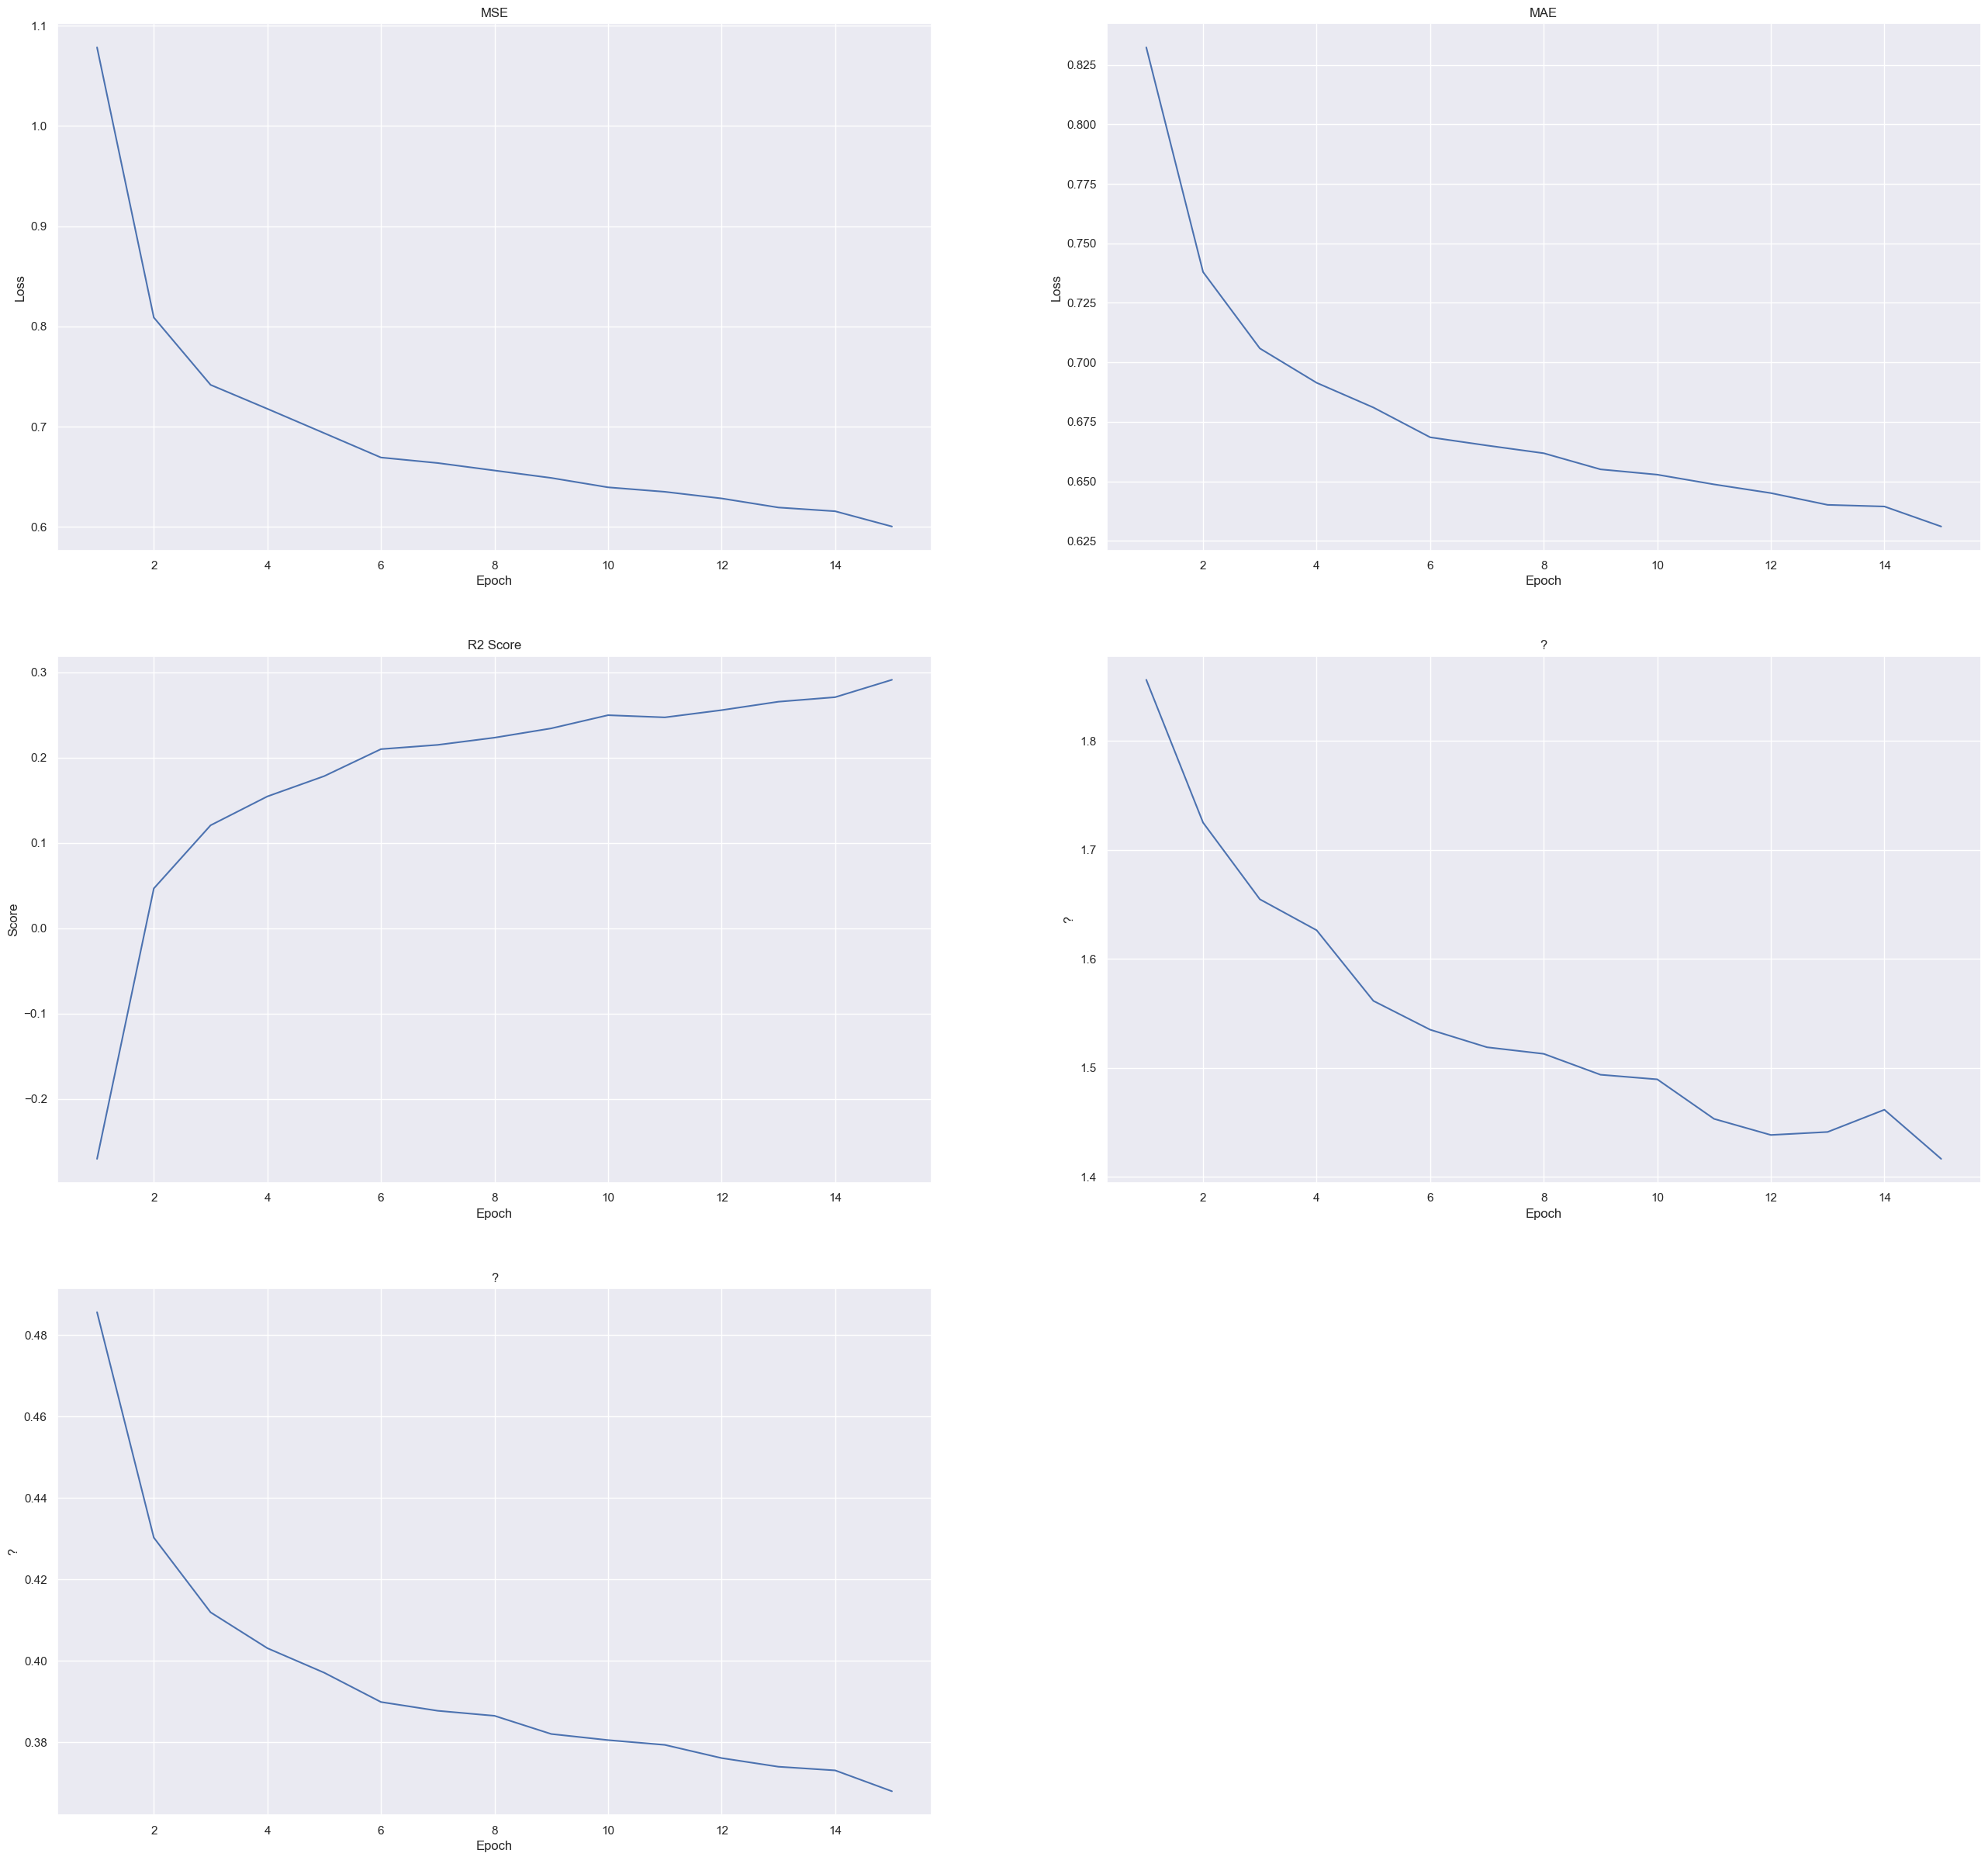

In [30]:
# Display the training metrics per batch

cnn_plot.show_metric_grid(
	report   = report,
	mode     = 'train',
	filename = os.path.join(OUT_PLOT, model.__name__ + '-train')
)

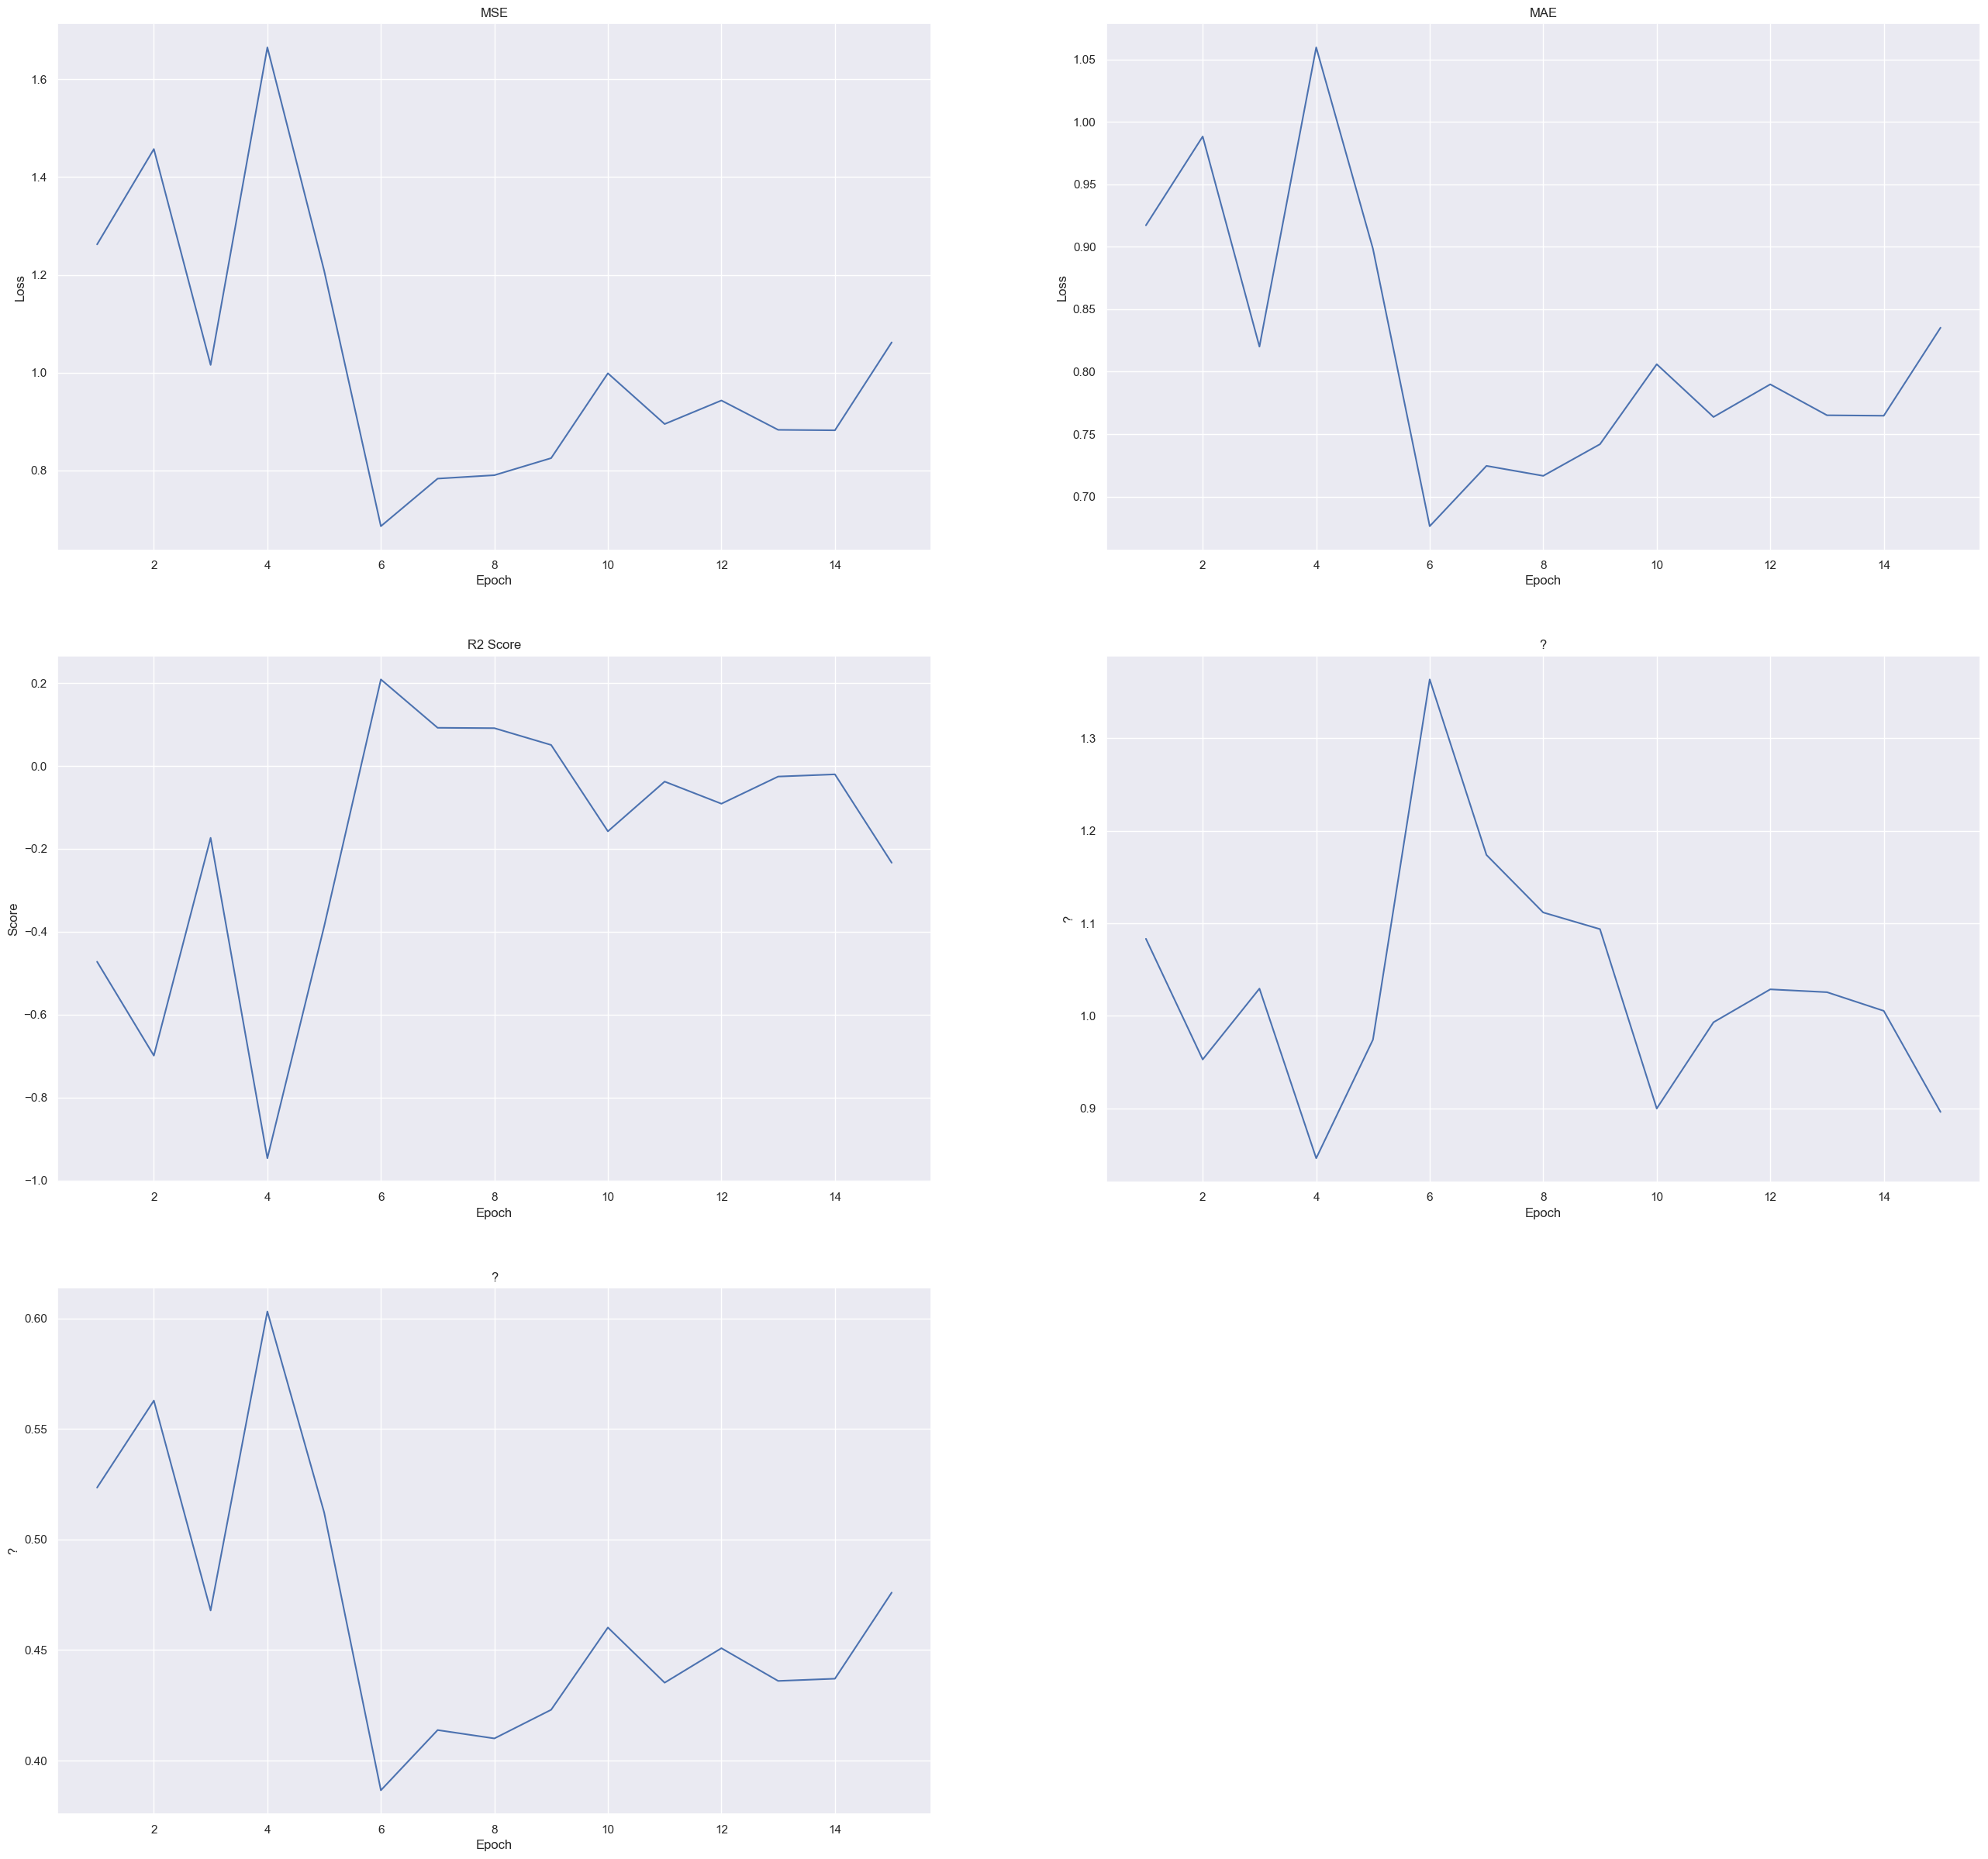

In [31]:
# Display the validation metrics per batch

cnn_plot.show_metric_grid(
	report   = report,
	mode     = 'valid',
	filename = os.path.join(OUT_PLOT, model.__name__ + '-valid')
)

# 5. Evaluation

## 5.1 Last Model

### 5.1.1 Evaluation

In [32]:
# Load last model

checkpoint = loader.load_torch(
	filename = os.path.join(OUT_MODEL, model.__name__ + '-last.pth')
)

final_report['evaluation/last/epoch'] = checkpoint['epoch']
final_report['evaluation/last/loss']  = checkpoint['loss']

print('Epoch : ' + '{}'.format(final_report['evaluation/last/epoch']))
print(' Loss : ' + '{:.5f}'.format(final_report['evaluation/last/loss']))

model.load_state_dict(checkpoint['models'])

Epoch : 15
 Loss : 1.06180


<All keys matched successfully>

In [33]:
# Evaluate the full model

report = cnn_model.eval_regressor(
	model  = model,
	params = model_params
)

final_report['evaluation/last/r2/mean']    = report['eval']['metric']['r2'].mean()
final_report['evaluation/last/mae/mean']   = report['eval']['metric']['mae'].mean()
final_report['evaluation/last/mse/mean']   = report['eval']['metric']['mse'].mean()
final_report['evaluation/last/mape/mean']  = report['eval']['metric']['mape'].mean()
final_report['evaluation/last/wmape/mean'] = report['eval']['metric']['wmape'].mean()

print('  R2 Score : ' + '{: 8.5f}'.format(final_report['evaluation/last/r2/mean']))
print('  MAE Loss : ' + '{: 8.5f}'.format(final_report['evaluation/last/mae/mean']))
print('  MSE Loss : ' + '{: 8.5f}'.format(final_report['evaluation/last/mse/mean']))
print(' MAPE Loss : ' + '{: 8.5f}'.format(final_report['evaluation/last/mape/mean']))
print('WMAPE Loss : ' + '{: 8.5f}'.format(final_report['evaluation/last/wmape/mean']))

  R2 Score : -0.18016
  MAE Loss :  0.81143
  MSE Loss :  1.00023
 MAPE Loss :  1.06019
WMAPE Loss :  0.46966


## 5.2 Best Model

### 5.2.1 Evaluation

In [34]:
# Load best model

checkpoint = loader.load_torch(
	filename = os.path.join(OUT_MODEL, model.__name__ + '-best.pth')
)

final_report['evaluation/best/epoch'] = checkpoint['epoch']
final_report['evaluation/best/loss']  = checkpoint['loss']

print('Epoch : ' + '{}'.format(final_report['evaluation/best/epoch']))
print(' Loss : ' + '{:.5f}'.format(final_report['evaluation/best/loss']))

model.load_state_dict(checkpoint['models'])

Epoch : 6
 Loss : 0.68562


<All keys matched successfully>

In [35]:
# Evaluate the full model

report = cnn_model.eval_regressor(
	model  = model,
	params = model_params
)

final_report['evaluation/best/r2/mean']    = report['eval']['metric']['r2'].mean()
final_report['evaluation/best/mae/mean']   = report['eval']['metric']['mae'].mean()
final_report['evaluation/best/mse/mean']   = report['eval']['metric']['mse'].mean()
final_report['evaluation/best/mape/mean']  = report['eval']['metric']['mape'].mean()
final_report['evaluation/best/wmape/mean'] = report['eval']['metric']['wmape'].mean()

print('  R2 Score : ' + '{: 8.5f}'.format(final_report['evaluation/best/r2/mean']))
print('  MAE Loss : ' + '{: 8.5f}'.format(final_report['evaluation/best/mae/mean']))
print('  MSE Loss : ' + '{: 8.5f}'.format(final_report['evaluation/best/mse/mean']))
print(' MAPE Loss : ' + '{: 8.5f}'.format(final_report['evaluation/best/mape/mean']))
print('WMAPE Loss : ' + '{: 8.5f}'.format(final_report['evaluation/best/wmape/mean']))

  R2 Score :  0.22435
  MAE Loss :  0.66262
  MSE Loss :  0.65335
 MAPE Loss :  1.67446
WMAPE Loss :  0.38534


### 5.2.2 Custom

In [36]:
# Display the first few evaluation item predictions and expectations

cnn_utils.display_regression_predictions(report = report, n = 2)

 Key : AT5G01910.1
True : [ 1.15197]
Pred : [ 2.20913]
 MAE : [ 1.05717]
 MSE : [ 1.11760]
  R2 : [ 0.09770]

 Key : AT1G30545.1
True : [ 0.70104]
Pred : [ 1.72284]
 MAE : [ 1.02179]
 MSE : [ 1.04406]
  R2 : [ 0.22481]



### 5.2.3 Visualization

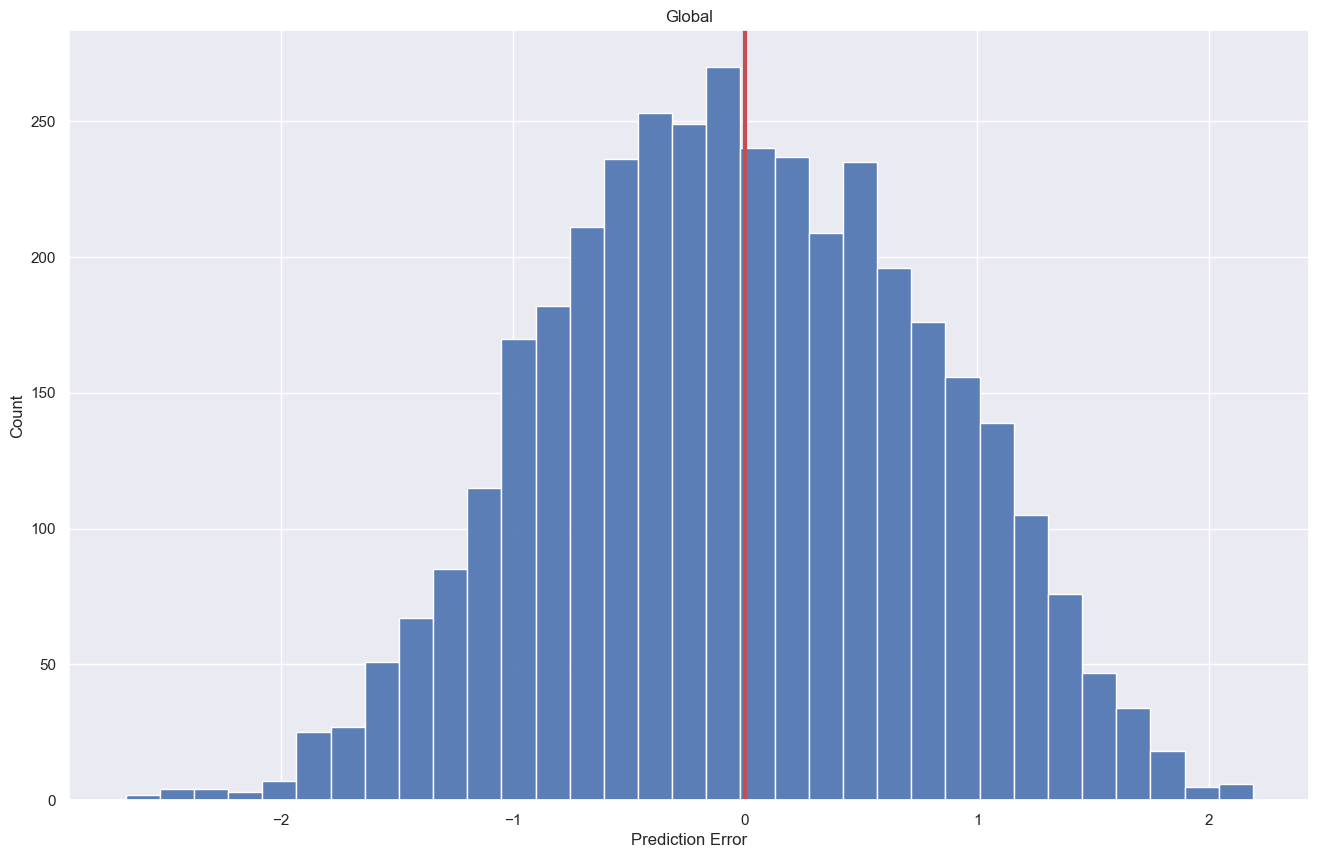

In [37]:
# Display prediction error per group

cnn_plot.show_prediction_error_grid(
	report   = report,
	order    = target_order,
	filename = os.path.join(OUT_PLOT, model.__name__ + '-best')
)

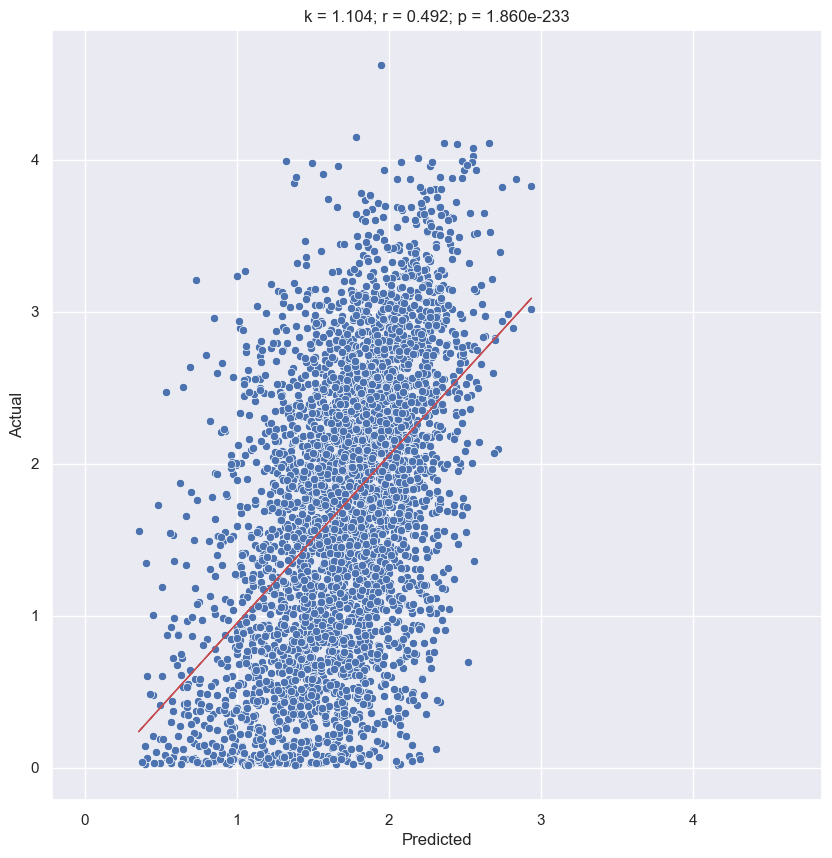

In [38]:
# Display prediction linear regression per group

cnn_plot.show_linear_regression_grid(
	report   = report,
	order    = target_order,
	filename = os.path.join(OUT_PLOT, model.__name__ + '-best')
)

### 5.2.4 Mutation

In [39]:
# Evaluate the mutations

report = cnn_model.eval_regressor(
	model  = model,
	params = model_params | {
		'test_dataloader' : mutation_dataloader,
		'metrics' : {
			'mse'   : cnn_model.get_criterion(reduction = 'none', weights = None, query = 'mse').to(DEVICE),
			'mae'   : cnn_model.get_criterion(reduction = 'none', weights = None, query = 'mae').to(DEVICE)
		}
	}
)

final_report['mutation/best/mae/mean'] = report['eval']['metric']['mae'].mean()
final_report['mutation/best/mse/mean'] = report['eval']['metric']['mse'].mean()

print('MAE Loss : ' + '{: 8.5f}'.format(final_report['mutation/best/mae/mean']))
print('MSE Loss : ' + '{: 8.5f}'.format(final_report['mutation/best/mse/mean']))

MAE Loss :  0.52485
MSE Loss :  0.38730


In [40]:
# Transform model report to mutation report

mutation_report = cnn_mutation.get_mutation_report(report = report)

transcript = list(mutation_report.keys())[0]
mutation   = list(mutation_report[transcript].keys())[0]

print('Transcripts : {}'.format(len(mutation_report)))
print('Mutations   : {}'.format(len(mutation_report[transcript])))
print('Variants    : {}'.format(len(mutation_report[transcript][mutation]['label'])))

Transcripts : 25
Mutations   : 6
Variants    : 20


In [41]:
# Print mutations

print(' ' + ' '.join('{:>20s}'.format(x) if i % 5 != 0 else '{:>20s}'.format(x) + '\n' for i, x in enumerate(mutation_report.keys(), start = 1)))

          AT3G48240.1          AT1G54180.2          AT3G20780.1          AT1G78830.1          AT5G59240.1
          AT4G11630.1          AT1G71790.1          AT1G14060.1          AT1G17850.2          AT5G02010.1
          AT5G08139.1          AT5G61950.1          AT1G44830.1          AT2G23520.1          AT4G10430.3
          AT5G46795.1          AT3G16260.1          AT3G61590.1          AT5G02940.1          AT4G18340.1
          AT5G50010.1          AT4G26965.1          AT3G19100.1          AT3G52561.1          AT1G50640.1



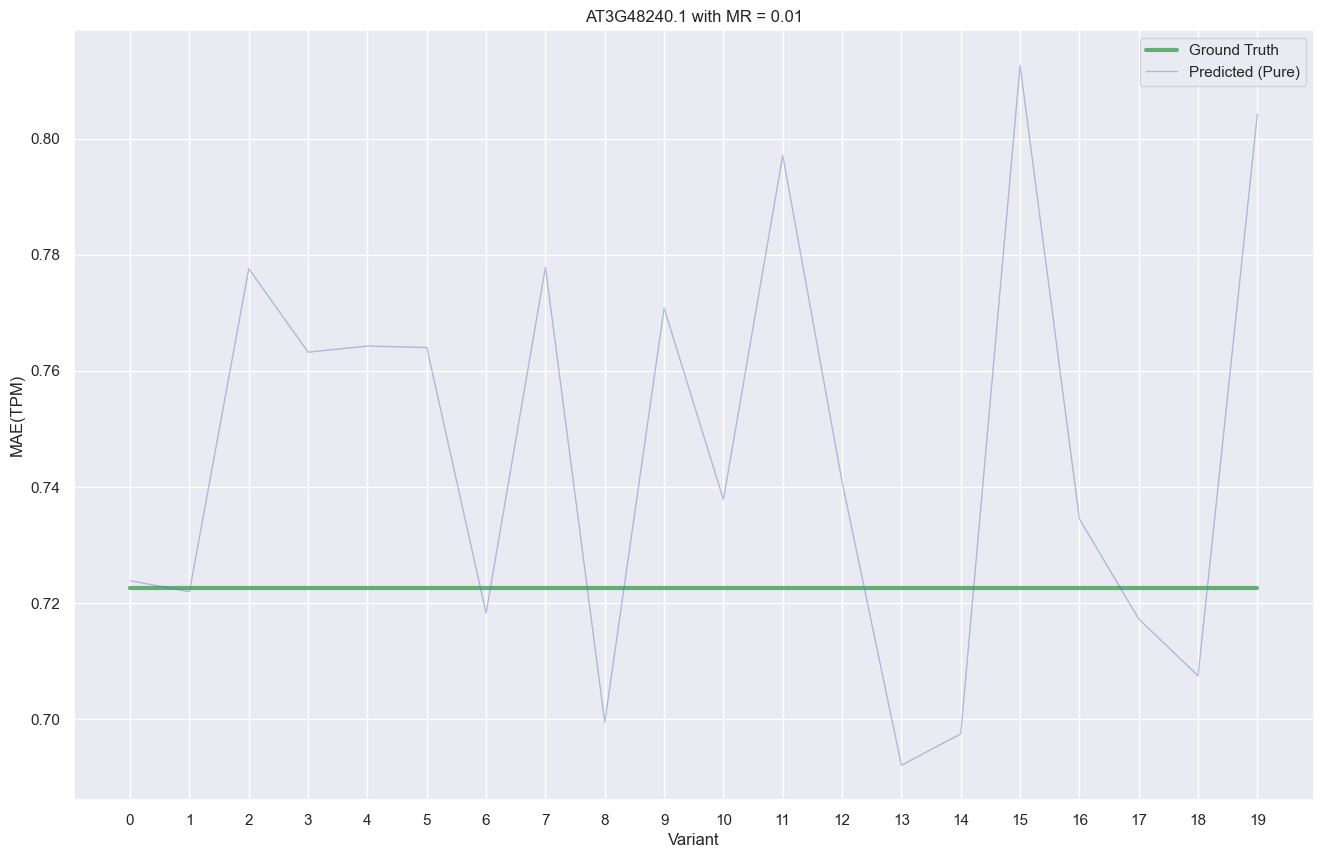

In [42]:
# Plot single transcript mutation variant predictions

cnn_mutation.plot_mutation_regression(
	report     = mutation_report,
	transcript = None,
	mutation   = 'M01',
	order      = target_order,
	filename   = os.path.join(OUT_PLOT, model.__name__ + '-mutation-m01')
)

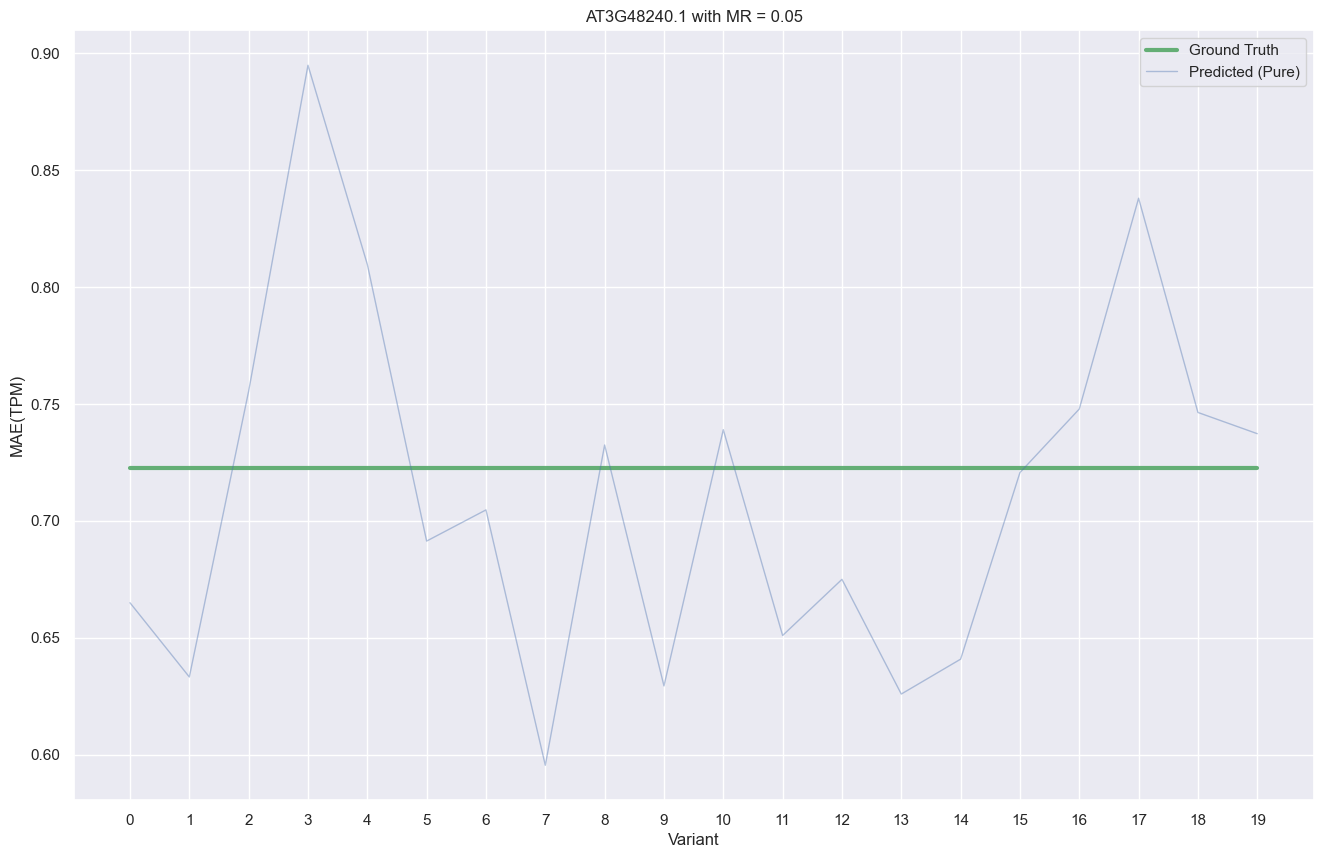

In [43]:
# Plot single transcript mutation variant predictions

cnn_mutation.plot_mutation_regression(
	report     = mutation_report,
	transcript = None,
	mutation   = 'M05',
	order      = target_order,
	filename   = os.path.join(OUT_PLOT, model.__name__ + '-mutation-m05')
)

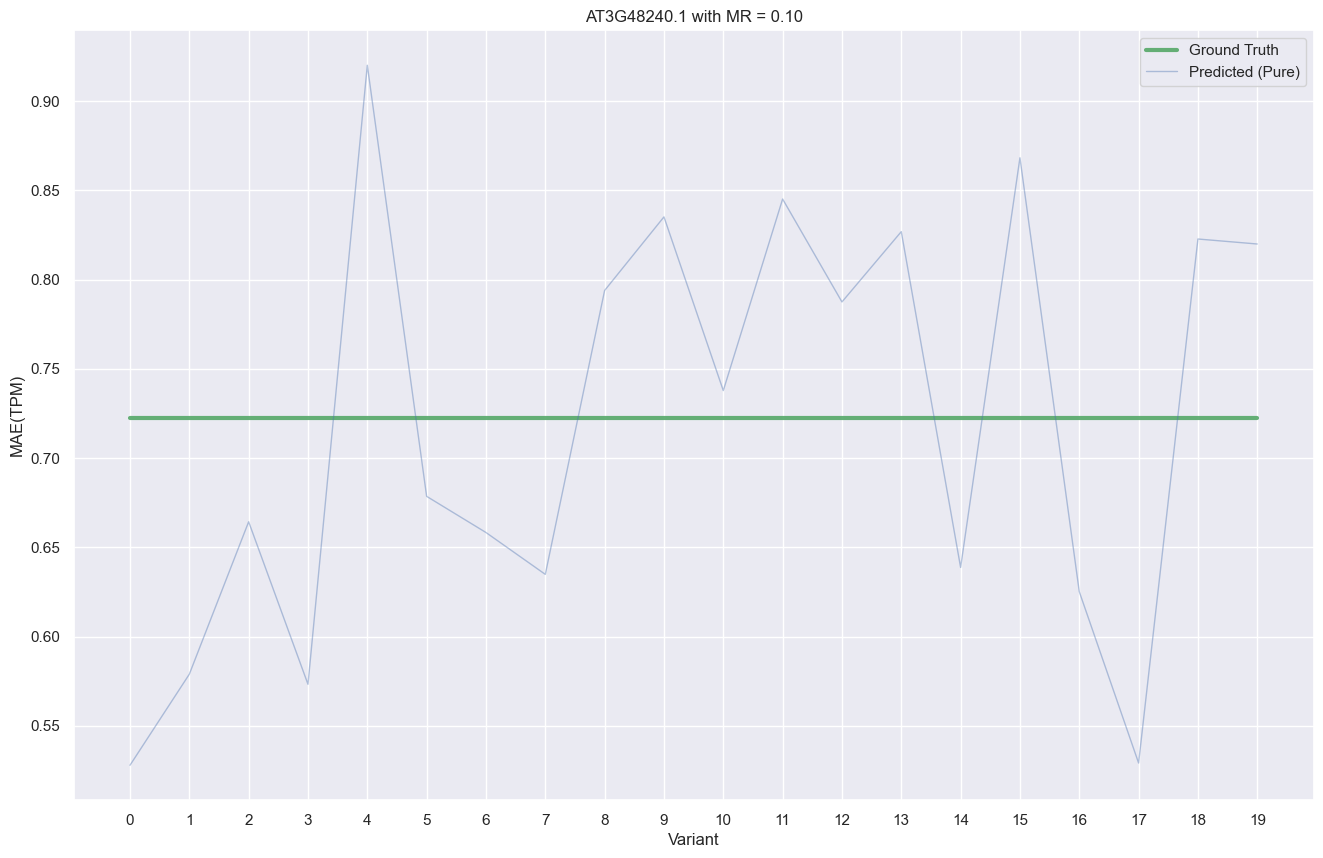

In [44]:
# Plot single transcript mutation variant predictions

cnn_mutation.plot_mutation_regression(
	report     = mutation_report,
	transcript = None,
	mutation   = 'M10',
	order      = target_order,
	filename   = os.path.join(OUT_PLOT, model.__name__ + '-mutation-m10')
)

# 6. Save

In [45]:
# Save results

for key, value in final_report.items() :
	if isinstance(value, numpy.float32) :
		final_report[key] = float(value)

writer.write_json(
	data     = final_report,
	filename = os.path.join(OUT_DATA, 'report.json')
)

writer.write_json(
	data     = {k : v for k, v in CONFIG.items() if k != 'core/device'},
	filename = os.path.join(OUT_DATA, 'config.json')
)